In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import seaborn as sns
import os
import json
from itertools import permutations
from sklearn.decomposition import PCA
import umap.umap_ as umap

np.random.seed(42)

%matplotlib inline
sns.set_context('poster')
sns.set_style('white')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.5, 's' : 80, 'linewidths':0}

In [2]:
# Set data input folder
input_folder = "inputs"

# Set output folder, subfolder
output_folder = "outputs"
if not os.path.exists(output_folder):
    os.makedirs(output_folder, exist_ok=True)
if not os.path.exists(os.path.join(output_folder,"figure_panels")):
    os.makedirs(os.path.join(output_folder,"figure_panels"), exist_ok=True)

In [3]:
# Import the A549 guide-level profiles
df_guide = pd.read_csv("../Profile_Aggregation/outputs/20200805_A549_WG_Screen_guide_normalized_feature_select_merged_median_ALLBATCHES___CP186___ALLWELLS.csv.gz")
# Import the A549 gene-level profiles
df_gene = pd.read_csv("../Profile_Aggregation/outputs/20200805_A549_WG_Screen_guide_normalized_feature_select_merged_median_ALLBATCHES___CP186___ALLWELLS_gene_aggregated.csv.gz")

# Import the GO annotations
with open("../common_files/GO_gene_sets.json") as f:
    GO_dict = json.load(f)

# Load p_values from the hit calling process
df_p_values = pd.read_csv('../Hit_Calling/outputs/A549_significant_features_mann_whitney_p_values.csv.gz')
df_p_values = df_p_values.set_index('Gene')

# Load expression data 
with open("../Hit_Calling/outputs/A549_CCLE_expression_summary.json") as f:
    express = json.load(f)
    zero_tpm_list = express['zero_tpm']
    expressed_gene_list = express['expressed_genes']


# Figure 2A and 2B

In [4]:
# Extract the features
features = df_p_values.columns.to_list()
mito_list = [feature for feature in features if 'mito'  in feature.lower()]
cona_list = [feature for feature in features if 'cona'  in feature.lower()]
dapi_list = [feature for feature in features if 'dapi'  in feature.lower()]
wga_list = [feature for feature in features if 'wga'  in feature.lower()]
phalloidin_list = [feature for feature in features if 'phalloidin'  in feature.lower()]
print('Number of features per compartment: ','\n',
      'Mito features: ',len(mito_list),'\n',
      'ConA features: ',len(cona_list),'\n',
      'DAPI features: ',len(dapi_list),'\n',
      'WGA features: ',len(wga_list),'\n',
      'Phalloidin features: ',len(phalloidin_list))

Number of features per compartment:  
 Mito features:  346 
 ConA features:  221 
 DAPI features:  321 
 WGA features:  285 
 Phalloidin features:  254


In [5]:
# Quantification of number of significant features per compartment at a certain p-value
p_value = 0.001
gene_list = list(df_p_values.index)

df_sig_feature = pd.DataFrame(index=gene_list)
for gene in gene_list:
    # Count mito features 
    mito_c = 0 
    for feat in mito_list:
        if df_p_values.loc[gene,feat] < p_value:
            mito_c += 1 
    # Count cona features 
    cona_c = 0 
    for feat in cona_list:
        if df_p_values.loc[gene,feat] < p_value:
            cona_c += 1 
    # Count wga features 
    wga_c = 0 
    for feat in wga_list:
        if df_p_values.loc[gene,feat] < p_value:
            wga_c += 1 
    # Count dapi features 
    dapi_c = 0 
    for feat in dapi_list:
        if df_p_values.loc[gene,feat] < p_value:
            dapi_c += 1 
    # Count wga features 
    phal_c = 0 
    for feat in phalloidin_list:
        if df_p_values.loc[gene,feat] < p_value:
            phal_c += 1 
    # Count all features
    sum_c = 0
    for feat in features:
        if df_p_values.loc[gene,feat] < p_value:
            sum_c += 1 
            
    df_sig_feature.loc[gene,'Mito'] = mito_c
    df_sig_feature.loc[gene,'ConA'] = cona_c
    df_sig_feature.loc[gene,'WGA'] = wga_c
    df_sig_feature.loc[gene,'DAPI'] = dapi_c
    df_sig_feature.loc[gene,'Phalloidin'] = phal_c
    df_sig_feature.loc[gene,'Sum'] = sum_c
    
df_sig_feature.head()

,Mito,ConA,WGA,DAPI,Phalloidin,Sum
A1BG,12.0,15.0,18.0,25.0,17.0,88.0
A1CF,12.0,9.0,16.0,18.0,27.0,89.0
A2M,21.0,13.0,11.0,49.0,20.0,124.0
A2ML1,15.0,13.0,12.0,23.0,14.0,81.0
A3GALT2,32.0,13.0,17.0,37.0,17.0,115.0


In [6]:
# Perturbations divided into 2 groups of controls with 0 TPM and others
df_sig_feature_zero_tpm = df_sig_feature.loc[zero_tpm_list]
df_sig_feature_expressed = df_sig_feature.loc[expressed_gene_list]
df_sig_feature_zero_tpm.head()

,Mito,ConA,WGA,DAPI,Phalloidin,Sum
A2M,21.0,13.0,11.0,49.0,20.0,124.0
A3GALT2,32.0,13.0,17.0,37.0,17.0,115.0
AADACL2,19.0,12.0,11.0,15.0,13.0,71.0
AADACL3,13.0,9.0,13.0,14.0,15.0,67.0
AADACL4,11.0,12.0,16.0,17.0,16.0,78.0


In [7]:
# Function for false discovery rate (FDR) calculation

def FDR_5(control_sig_feature):
    total = len(control_sig_feature)
    FDR_5 = int(total/20)
    mito_5, cona_5, wga_5, dapi_5, phal_5, sum_5 = 0,0,0,0,0,0
    channels = ['Mito','ConA','WGA','DAPI','Phalloidin']
    c = 200
    feat_5 = 0
    while feat_5 <= FDR_5:
        feat_5 = len(control_sig_feature.query('Mito > @c'))
        mito_5 = c + 1
        c-=1    
    
    c = 200
    feat_5 = 0
    while feat_5 <= FDR_5:
        feat_5 = len(control_sig_feature.query('ConA > @c'))
        cona_5 = c + 1
        c-=1     
        
    c = 200
    feat_5 = 0
    while feat_5 <= FDR_5:
        feat_5 = len(control_sig_feature.query('WGA > @c'))
        wga_5 = c + 1
        c-=1    
    
    c = 200
    feat_5 = 0
    while feat_5 <= FDR_5:
        feat_5 = len(control_sig_feature.query('DAPI > @c'))
        dapi_5 = c + 1
        c-=1    
    
    c = 200
    feat_5 = 0
    while feat_5 <= FDR_5:
        feat_5 = len(control_sig_feature.query('Phalloidin > @c'))
        phal_5 = c + 1
        c-=1    
        
    c = 200
    feat_5 = 0
    while feat_5 <= FDR_5:
        feat_5 = len(control_sig_feature.query('Sum > @c'))
        sum_5 = c + 1
        c-=1    
    
    return mito_5, cona_5, wga_5, dapi_5, phal_5, sum_5


In [8]:
# Compute and print the threshold for FDR calculations at 5% from the 0 TPM gene perturbations
mito_5, cona_5, wga_5, dapi_5, phal_5,sum_5 = FDR_5(df_sig_feature_zero_tpm)
print('Mito genes', mito_5, '\n', 
      'ConA genes', cona_5, '\n', 
      'WGA genes', wga_5, '\n', 
      'DAPI genes', dapi_5, '\n', 
      'Phalloidin genes', phal_5, '\n',
      'Whole Profile genes', sum_5)

Mito genes 36 
 ConA genes 23 
 WGA genes 36 
 DAPI genes 52 
 Phalloidin genes 31 
 Whole Profile genes 166


In [9]:
# Save the number of significant features per channel for whole cell hits and compartment hits
A549_whole_cell_hits = df_sig_feature_expressed.query('Sum > @sum_5')
A549_comp_spec_hits = df_sig_feature_expressed.query('Sum <= @sum_5').query('Phalloidin > @phal_5 | DAPI > @dapi_5 | WGA > @wga_5 | ConA > @cona_5 | Mito > @mito_5')
A549_whole_cell_hits.to_csv(os.path.join(output_folder,'A549_plate_level_median_per_feat_sig_genes_5_FDR_whole_cell_hits.csv'),index=True)
A549_comp_spec_hits.to_csv(os.path.join(output_folder,'A549_plate_level_median_per_feat_sig_genes_5_FDR_compartment_specific_hits.csv'),index=True)
A549_whole_cell_hits.head()

,Mito,ConA,WGA,DAPI,Phalloidin,Sum
AAAS,28.0,15.0,43.0,53.0,24.0,171.0
AAMP,18.0,13.0,31.0,35.0,84.0,185.0
ABCA1,37.0,19.0,48.0,27.0,33.0,174.0
ABCA10,27.0,21.0,63.0,67.0,26.0,199.0
ABCB7,32.0,20.0,26.0,108.0,20.0,222.0


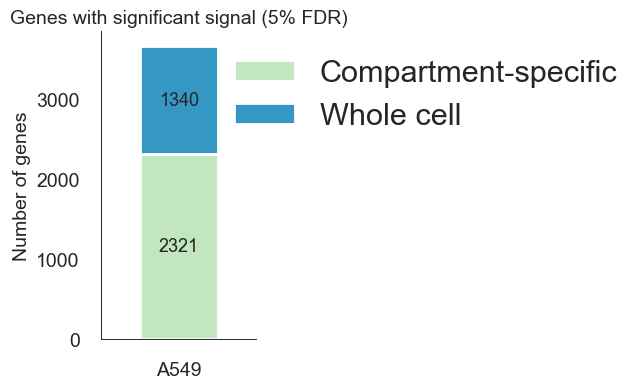

In [10]:
# Plot hits summary for Fig 2A
A549_whole_cell = len(df_sig_feature_expressed.query('Sum > @sum_5'))
A549_comp_spec = len(df_sig_feature_expressed.query('Sum <= @sum_5').query('Phalloidin > @phal_5 | DAPI > @dapi_5 | WGA > @wga_5 | ConA > @cona_5 | Mito > @mito_5'))

mpl.rc('axes', linewidth=0.7)
mpl.rc('xtick', labelsize=14)
mpl.rc('xtick', labelsize=14)

fig, ax = plt.subplots( figsize=(2,4))
colors = sns.color_palette('GnBu')[:8]
hits_plot = pd.DataFrame({'Compartment-specific': [A549_comp_spec],
                         'Whole cell': [A549_whole_cell] },
                        index=['A549'])

hits_plot.plot(kind='bar', 
               stacked=True,
               color=[colors[1], colors[4]],
               legend = 'reverse',
               rot = 0,
               fontsize= 14,
               width = 0.5,
               ax=ax)

ax.set_title('Genes with significant signal (5% FDR)',size=14)
ax.set_ylabel('Number of genes',size=14)

ax.bar_label(ax.containers[0],label_type='center',size=13)
ax.bar_label(ax.containers[1],label_type='center',size=13)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(loc="upper left", bbox_to_anchor=(0.68,1),frameon=False, ncol=1)
fig.savefig(os.path.join(output_folder,'figure_panels','Fig2A_A549_whole_cell_compartment_specific_hits.png'),dpi = 300,bbox_inches='tight')

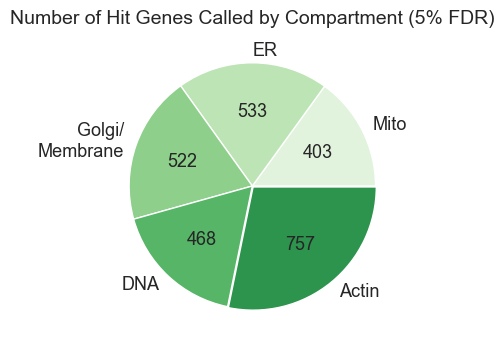

In [11]:
# Plot hits summary for Fig 2B

def absolute_value2(val):
    a  = data[np.abs(data - val/100.*sum(data)).argmin() ]
    return a

labels = ['Mito','ER','Golgi/\nMembrane','DNA','Actin']
data = [len(df_sig_feature_expressed.query('Mito > @mito_5 & Sum <= @sum_5')),
        len(df_sig_feature_expressed.query('ConA > @cona_5 & Sum <= @sum_5')),
        len(df_sig_feature_expressed.query('WGA > @wga_5 & Sum <= @sum_5')),
        len(df_sig_feature_expressed.query('DAPI > @dapi_5 & Sum <= @sum_5')),
        len(df_sig_feature_expressed.query('Phalloidin > @phal_5 & Sum <= @sum_5'))]

colors = sns.color_palette('Greens')[:5]
               
fig, ax = plt.subplots(figsize=(7,4))

sns.set_theme(style='white',palette='RdBu')
plt.pie(data,
        labels=labels,
        autopct=absolute_value2,
        colors=colors,
        textprops={'fontsize': 13},
        explode=(0.0, 0.0, 0.0, 0.0, 0.01))
ax.set_title('Number of Hit Genes Called by Compartment (5% FDR)',size=14)
fig.savefig(os.path.join(output_folder,'Fig2B_A549_compartment_specific_hits_distribution.png'),dpi = 300,bbox_inches='tight')

# Figure 2C

In [17]:
hit_list = list(A549_comp_spec_hits.index) + list(A549_whole_cell_hits.index)
df_hits = df_gene.loc[df_gene['Metadata_Foci_Barcode_MatchedTo_GeneCode'].isin(hit_list)].set_index('Metadata_Foci_Barcode_MatchedTo_GeneCode')
df_hits.head()

,Metadata_Foci_Barcode_MatchedTo_GeneCode,Cells_AreaShape_CentralMoment_0_1,Cells_AreaShape_CentralMoment_0_3,Cells_AreaShape_CentralMoment_1_0,Cells_AreaShape_CentralMoment_1_2,Cells_AreaShape_Eccentricity,Cells_AreaShape_Extent,Cells_AreaShape_FormFactor,Cells_AreaShape_HuMoment_1,Cells_AreaShape_HuMoment_6,...,Nuclei_Texture_SumVariance_ConA_5_01_256,Nuclei_Texture_SumVariance_DAPI_Painting_10_01_256,Nuclei_Texture_SumVariance_DAPI_Painting_10_03_256,Nuclei_Texture_SumVariance_Mito_5_01_256,Nuclei_Texture_SumVariance_Phalloidin_10_01_256,Nuclei_Texture_SumVariance_Phalloidin_10_03_256,Nuclei_Texture_SumVariance_Phalloidin_5_01_256,Nuclei_Texture_SumVariance_WGA_10_01_256,Nuclei_Texture_SumVariance_WGA_10_03_256,Nuclei_Texture_SumVariance_WGA_5_03_256
0,AAAS,0.053542,0.014408,0.048916,0.024674,0.199330,0.456025,-0.040527,-0.159384,0.002850,...,-0.283220,-0.408740,-0.520060,-0.027163,-0.000137,-0.168190,-0.135835,-0.057649,0.026236,-0.016908
1,AAMP,0.076100,0.001463,-0.011151,0.029308,0.329480,-0.012306,-0.162878,-0.102137,0.003059,...,-0.050787,-0.744528,-0.314682,-0.038622,0.044990,0.196703,0.170772,-0.232923,-0.317620,-0.132316
2,AARS,-0.045047,-0.017224,-0.072438,0.005527,-0.053934,0.153853,0.393330,-0.232846,0.002481,...,0.042180,-0.265725,-0.159218,0.071226,-0.074440,-0.002175,-0.083249,0.008703,-0.023501,-0.042191
3,AARS2,-0.051243,0.009448,0.026790,-0.043807,-0.012882,-0.232335,0.147636,-0.219370,0.002847,...,-0.353250,-0.279907,-0.332005,-0.075201,-0.003135,-0.015622,-0.047501,-0.237655,-0.188850,-0.149119
4,ABCA1,-0.021621,0.001444,-0.029651,0.025454,-0.053920,0.368422,0.094167,-0.093550,0.002959,...,-0.302963,-0.131546,-0.005993,-0.053637,-0.041902,-0.101282,-0.112240,-0.149535,-0.258358,-0.049922


In [24]:
# Calculate correlation between all gene pairs and create a dictionary of gene pairs/correlation
df_hits_corr = df_hits.T.corr()
genes = list(df_hits_corr.index)
corr_dic = {}
for gene1 in genes:
    for gene2 in genes:
        if len(frozenset([gene1,gene2])) == 1 :
            continue
        else:    
            corr_dic[frozenset([gene1,gene2])]=(df_hits_corr.loc[gene1,gene2])
        
print(f'Gene pair correlation dictionary contains {len(corr_dic)} entries')

Gene pair correlation dictionary contains 6699630 entries


In [26]:
# Input the protein clusters from the CORUM3.0 database and subset the human clusters
ppi_data = pd.read_csv(f'{input_folder}/CORUM_allComplexes.txt',sep = '\t')
ppi_data_h = ppi_data[ppi_data['Organism'] == "Human"]
ppi_data_h.head()

,ComplexID,ComplexName,Organism,Synonyms,Cell line,subunits(UniProt IDs),subunits(Entrez IDs),Protein complex purification method,GO ID,GO description,FunCat ID,FunCat description,subunits(Gene name),Subunits comment,PubMed ID,Complex comment,Disease comment,SWISSPROT organism,subunits(Gene name syn),subunits(Protein name)
0,1,BCL6-HDAC4 complex,Human,None,None,P41182;P56524,604;9759,MI:0007-anti tag coimmunoprecipitation,GO:0006265;GO:0045892;GO:0051276;GO:0030183;GO...,DNA topological change;negative regulation of ...,10.01.09.05;11.02.03.04.03;42.10.03;43.03.07.0...,DNA conformation modification (e.g. chromatin)...,BCL6;HDAC4,None,11929873,Transcriptional repression by BCL6 is thought ...,None,Homo sapiens (Human);Homo sapiens (Human),BCL5 LAZ3 ZBTB27 ZNF51;KIAA0288,B-cell lymphoma 6 protein;Histone deacetylase 4
1,2,BCL6-HDAC5 complex,Human,None,None,P41182;Q9UQL6,604;10014,MI:0007-anti tag coimmunoprecipitation,GO:0006265;GO:0045892;GO:0051276;GO:0030183;GO...,DNA topological change;negative regulation of ...,10.01.09.05;11.02.03.04.03;42.10.03;43.03.07.0...,DNA conformation modification (e.g. chromatin)...,BCL6;HDAC5,None,11929873,Transcriptional repression by BCL6 is thought ...,None,Homo sapiens (Human);Homo sapiens (Human),BCL5 LAZ3 ZBTB27 ZNF51;KIAA0600,B-cell lymphoma 6 protein;Histone deacetylase 5
2,3,BCL6-HDAC7 complex,Human,None,None,P41182;Q8WUI4,604;51564,MI:0007-anti tag coimmunoprecipitation,GO:0006265;GO:0045892;GO:0051276;GO:0030183;GO...,DNA topological change;negative regulation of ...,10.01.09.05;11.02.03.04.03;42.10.03;43.03.07.0...,DNA conformation modification (e.g. chromatin)...,BCL6;HDAC7,None,11929873,Transcriptional repression by BCL6 is thought ...,None,Homo sapiens (Human);Homo sapiens (Human),BCL5 LAZ3 ZBTB27 ZNF51;HDAC7A,B-cell lymphoma 6 protein;Histone deacetylase 7
3,4,Multisubunit ACTR coactivator complex,Human,None,None,Q09472;Q92793;Q92831;Q9Y6Q9,2033;1387;8850;8202,MI:0004-affinity chromatography technologies;M...,GO:0045893;GO:0023052;GO:0005634,"positive regulation of transcription, DNA-temp...",11.02.03.04.01;30.01;70.10,transcription activation;cellular signalling;n...,EP300;CREBBP;KAT2B;NCOA3,None,9267036,Cofactor ACTR binds directly nuclear receptors...,None,Homo sapiens (Human);Homo sapiens (Human);Homo...,"P300;CBP;PCAF;AIB1, BHLHE42, RAC3, TRAM1, ACTR",Histone acetyltransferase p300;CREB-binding pr...
5,10,Condensin I complex,Human,13S condensin complex,None,O95347;Q15003;Q15021;Q9BPX3;Q9NTJ3,10592;23397;9918;64151;10051,MI:0004-affinity chromatography technologies;M...,GO:0000279;GO:0007067;GO:0030261;GO:0007059;GO...,M phase;mitotic nuclear division;chromosome co...,10.03.01.01.11;10.03.04.03;10.03.04.05;42.10.0...,M phase;chromosome condensation;chromosome seg...,SMC2;NCAPH;NCAPD2;NCAPG;SMC4,None,11136719,None,None,Homo sapiens (Human);Homo sapiens (Human);Homo...,CAPE SMC2L1;BRRN BRRN1 CAPH KIAA0074;CAPD2 CNA...,Structural maintenance of chromosomes protein ...


In [27]:
# Create a list of protein clusters with all complexes that had at least 66% of genes represented within the A549 WGS hits
cluster_count = 0
hit_cluster_list_list = []
hit_set = set()
for i in range(len(ppi_data_h)):
    cluster = ppi_data_h.iloc[i]['subunits(Gene name)'].split(';')
    count = 0
    hit_cluster_list = []
    for g in cluster:
        if g in genes:
            count += 1
            hit_set.add(g)
            hit_cluster_list.append(g)
    if (count/len(cluster)) >= 0.66:
        cluster_count += 1
    if hit_cluster_list and (count/len(cluster)) >= 0.66:
        hit_cluster_list_list.append(hit_cluster_list)
print(f'There are {len(hit_set)} ')
print(f'There are {cluster_count} ')
print(f'There are {len(hit_cluster_list_list)} ')

There are 1123 
There are 445 
There are 445 


In [28]:
# Assign correlations to hit gene pairs
hit_pair_set = set()
for l in hit_cluster_list_list:
    for c in list(permutations(l,2)):
        hit_pair_set.add(frozenset(c))

hit_corr_dic = {}
for s in hit_pair_set:
    hit_corr_dic[s] = corr_dic[s]

print(f'There are {len(hit_pair_set)} hit pairs.')
print(f'There are {len(hit_corr_dic)} hit pairs with correlation.')

There are 2889 hit pairs.
There are 2889 hit pairs with correlation.


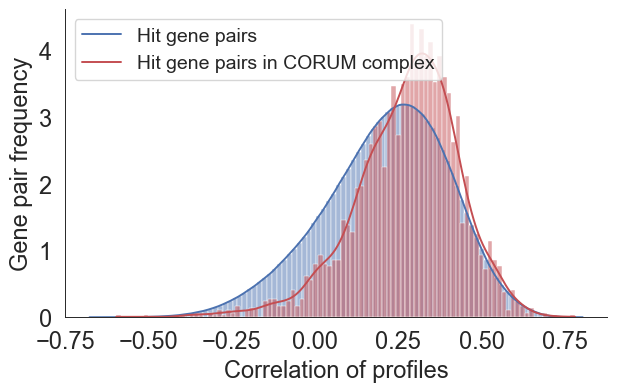

In [29]:
# Plot CORUM gene pair correlation distribution for Fig 2C
sns.set_theme(style="white",rc = {'axes.linewidth': 0.7,'xtick.labelsize':17,'ytick.labelsize':17})

fig, ax = plt.subplots(figsize=(7,4))
a = list(corr_dic.values())
b = list(hit_corr_dic.values())

sns.histplot(a ,color='b' ,stat= 'percent' ,bins= 100, kde=True, line_kws={'lw':1.4} , alpha=0.5,ax = ax);
sns.histplot(b ,color='r' ,stat= 'percent' ,bins= 100, kde=True, line_kws={'lw':1.4} ,alpha=0.5,ax = ax);

ax.set_ylabel('Gene pair frequency',size=17)
ax.set_xlabel('Correlation of profiles',size=17)
font = font_manager.FontProperties(size=14)
ax.legend(['Hit gene pairs','Hit gene pairs in CORUM complex'],loc='upper left',prop=font )
sns.despine(top = True)

fig.savefig(os.path.join(output_folder,'figure_panels','Fig2C_A549_CORUM_gene_pair_correlation_distribution.png'), dpi=300,facecolor='w', edgecolor='w', bbox_inches='tight')
plt.show()

# Figure 2D

In [ ]:
# Import predicted protein links from v11.5 of STRING (9606.protein.links.v11.5.txt.gz) as well as the metadata (9606.protein.info.v11.5.txt.gz)
# Then parse the data into a dataframe
ppi_data = pd.read_csv(os.path.join(input_folder,'9606.protein.links.v11.5.txt.gz'),sep = ' ')
p_names = pd.read_csv(os.path.join(input_folder,'9606.protein.info.v11.5.txt.gz'),sep = '\t')

p_names_dic = {p_names.iloc[i]['#string_protein_id']:p_names.iloc[i]['preferred_name'] for i in range(len(p_names))}

p1 = list(ppi_data.protein1)
p2 = list(ppi_data.protein2)
score = list(ppi_data.combined_score)

p1_named = [p_names_dic.get(item)  for item in p1]
p2_named = [p_names_dic.get(item)  for item in p2]

ppi_data_name = pd.DataFrame(list(zip(p1_named, p2_named, score)),
               columns =['protein1', 'protein2','combined_score'])
ppi_data_name.head()

In [ ]:
# Subset the STRING predicted protein links to A549 hits
ppi_data_name_hits = ppi_data_name[ppi_data_name['protein1'].isin(genes) & ppi_data_name['protein2'].isin(genes)]
print(f'Full PPI database is {ppi_data_name.shape()}')
print(f'PPI database subsetted to A549 hits is {ppi_data_name_hits.shape()}')

In [ ]:
# Catalogue all correlations
corr_dic = {}
for gene1 in genes:
    for gene2 in genes:
        if len(frozenset([gene1,gene2])) == 1 :
            continue
        else:    
            corr_dic[frozenset([gene1,gene2])]=(df_hits_corr.loc[gene1,gene2])
        
print('Overall number of paired correlation ' , len(corr_dic))

In [ ]:
# Determine min, max, intervals for profile correlations
corr_min = min(corr_dic.values())
corr_max = max(corr_dic.values())   
interval = (corr_max-corr_min)/6
print(f'Minimum correlation is {corr_min}')
print(f'Maximum correlation is {corr_max}')
print(f'Interval for plotting with 6 bins is {interval}')

In [ ]:
# Bin the correlations into 6 categories 
results = ppi_data_name_hits.copy(deep=True).reset_index(drop=True)
results["correlation"] = ''
results["correlation_bin"] = ''

bins = [-0.81,-0.54,-0.27,0,0.27,0.54,0.81]
for i in range(len(results)):
    gene1 = results.iloc[i]['protein1']
    gene2 = results.iloc[i]['protein2']
    corr_value = corr_dic[frozenset([gene1,gene2])]
    results.at[i , 'correlation'] = corr_value
    if corr_value > bins[5]:
        results.at[i , 'correlation_bin'] = f'{bins[5]} to {bins[6]}'
    elif corr_value > bins[4] and corr_value <= bins[5]:
        results.at[i , 'correlation_bin'] = f'{bins[4]} to {bins[5]}'
    elif corr_value > bins[3] and corr_value <= bins[4]:
        results.at[i , 'correlation_bin'] = f'{bins[3]} to {bins[4]}'
    elif corr_value > bins[2] and corr_value <= bins[3]:
        results.at[i , 'correlation_bin'] = f'{bins[2]} to {bins[3]}'
    elif corr_value > bins[1] and corr_value <= bins[2]:
        results.at[i , 'correlation_bin'] = f'{bins[1]} to {bins[2]}'
    elif corr_value <= bins[1]:
        results.at[i , 'correlation_bin'] = f'{bins[0]} to {bins[1]}'
results.head()

In [ ]:
# Plot STRING score x gene pair correlation for Fig 2D
sns.set_theme(style="white",rc = {'axes.linewidth': 0.7})

fig, ax = plt.subplots(figsize=(7,4))
order = [f'{bins[0]} to {bins[1]}',f'{bins[1]} to {bins[2]}',f'{bins[2]} to {bins[3]}',f'{bins[3]} to {bins[4]}',f'{bins[4]} to {bins[5]}',f'{bins[5]} to {bins[6]}']

flierprops = dict(markerfacecolor='white', markersize=0.1, linestyle='none')
sns.boxenplot(data=results,
            x = 'correlation_bin',
            y = 'combined_score', 
            #k_depth = 'trustworthy',
            #whis = [10, 90], 
            #flierprops = flierprops,
            order=order, 
            width = 0.6,
            palette = 'RdBu_r',
            ax=ax)

ax.set_xlabel('Correlation of profiles',size=16)
ax.set_ylabel('STRING score',size=16)
ax.tick_params(axis='both', which='major', labelsize=14)
labels = [item for item in ax.get_yticks()]
ax.set_yticklabels([str(round(float(label))) for label in labels], size=16)
ax.set_xticklabels(order, size=16,rotation=30)
sns.despine(top = True,left=False,bottom=False)

fig.savefig(os.path.join(output_folder,'figure_panels','Fig2D_A549_STRING_gene_pair_correlation_score.png'), 
            dpi=300,
            facecolor='w', 
            edgecolor='w', 
            bbox_inches='tight')
plt.show()

# Figure 2E

In [ ]:
# Function to calculate percentage of significant number of features from each channel
def df_maker(gene_group, df_genes):
    mito, cona, wga, dapi, phal = df_genes.Mito.mean(), df_genes.ConA.mean(), df_genes.WGA.mean(), df_genes.DAPI.mean(), df_genes.Phalloidin.mean()
    sum_all = df_genes.Sum.mean()

    data.loc[gene_group,'Mito'] = mito/sum_all*100
    data.loc[gene_group,'ConA'] = cona/sum_all*100
    data.loc[gene_group,'WGA'] = wga/sum_all*100
    data.loc[gene_group,'DAPI'] = dapi/sum_all*100
    data.loc[gene_group,'Phalloidin'] = phal/sum_all*100
    
    return data

In [ ]:
# Organize the data into a dataframe, the gene list are from the gene ontology data sets
gene_groups = ['Vacuolar-type ATPase','Protein O-mannosylation','Outer Mitochondrial Membrane Protein Complex',
               'Cortical Cytoskeleton','DNA Polymerase Complex']
data = pd.DataFrame(index=gene_groups)

# WGA
gene_group = 'Vacuolar-type ATPase' 
gene_list = GO_dict[gene_group]
df_genes = df_sig_feature.loc[gene_list]
df_genes = df_genes.reset_index().query('index in @expressed_gene_list')
data = df_maker(gene_group, df_genes)

#ConA
gene_group = 'Protein O-mannosylation'
gene_list = GO_dict[gene_group]
df_genes = df_sig_feature.loc[gene_list]
df_genes = df_genes.reset_index().query('index in @expressed_gene_list').query('index in @hits_list')
data = df_maker(gene_group, df_genes)

# Mito
gene_group = 'Outer Mitochondrial Membrane Protein Complex'
gene_list = GO_dict[gene_group]
df_genes = df_sig_feature.loc[gene_list]
df_genes = df_genes.reset_index().query('index in @expressed_gene_list').query('index in @hits_list')
data = df_maker(gene_group, df_genes)


#Phalloidin
gene_group = 'Cortical Cytoskeleton'
gene_list = GO_dict[gene_group]
df_genes = df_genes.reset_index().query('index in @expressed_gene_list').query('index in @hits_list')
data = df_maker(gene_group, df_genes)


#DAPI
gene_group = 'DNA Polymerase Complex'
gene_list = GO_dict[gene_group]
df_genes = df_sig_feature.loc[gene_list]
df_genes = df_genes.reset_index().query('index in @expressed_gene_list').query('index in @hits_list')
data = df_maker(gene_group, df_genes)

data

In [ ]:
# Plot fraction of features per compartments for Fig 2E
for gene in list(data.index):
    print(gene)
    # create data
    names = ['Mito','ER', 'Golgi/\nMembrane', 'DNA','Actin']
    size = data.loc[gene].values
 
    # Create a circle at the center of the plot
    my_circle = plt.Circle( (0,0), 0.7, color='white')

    # Custom wedges
    plt.pie(size, 
            labels=names, 
            wedgeprops = { 'linewidth' : 7, 'edgecolor' : 'white' },
            colors = ['lightcoral','orchid','lightblue','cornflowerblue','lightgreen'],
            autopct='%1.0f%%', 
            pctdistance=0.83)
    p = plt.gcf()
    p.gca().add_artist(my_circle)
    plt.savefig(os.path.join(output_folder,'figure_panels',f'Fig2E_A549_fraction_features_per_compartments_{gene}.png'), 
                dpi=300,
                facecolor='w', 
                edgecolor='w',
                bbox_inches='tight')
    plt.show()

# Figure 2F

In [ ]:
# Perform principal component analysis and select components representing 70% of variation in data & print the variation of components selected by PCA
pca = PCA()
pca.fit(df_hits)
x = list(pca.explained_variance_ratio_)
y = [sum(x[:i+1]) for i in range(len(x))]
y[139]

In [ ]:
# Perform principal component analysis and select components representing 70% of variation in data
pca = PCA(n_components=140)
df_hits_pca = pd.DataFrame(pca.fit_transform(df_hits),index=df_hits.index)
df_hits_pca.head()

In [ ]:
# Perform UMAP dimentionality reduction to project data into a 2-dimensional plane 
clusterable_embedding = umap.UMAP(
    n_neighbors=3,#3
    min_dist=0.0,
    n_components=2,
    random_state=43,
    metric = 'cosine',
).fit_transform(df_hits_pca)

In [ ]:
# Manually label highlighted hits  
overal_labels = [hit_list.index(i) if i in whole_cell_hit_list else -1 for i in hit_list ]
other_labels = [hit_list.index(i) if i not in whole_cell_hit_list else -1 for i in hit_list ]
highlight_categories = ['ENZYME_LINKED_RECEPTOR_PROTEIN_SIGNALING_PATHWAY','RIBONUCLEOPROTEIN_COMPLEX','GLYCOSYLATION','PROTEASOMAL_PROTEIN_CATABOLIC_PROCESS','PROCESS_UTILIZING_AUTOPHAGIC_MECHANISM','MITOCHONDRIAL_ENVELOPE','RRNA_METABOLIC_PROCESS','MRNA_PROCESSING','REGULATION_OF_GTPASE_ACTIVITY','TRANSLATIONAL_INITIATION']
highlight_list = [GO_dict[x] for x in highlight_categories]

highlight_labels = [hit_list.index(i) if i in highlight_list else -1 for i in hit_list ]
len(overal_labels)-other_labels.count(-1)

In [ ]:
# Plot the data and color code based on the type of hit.
plt.figure(figsize=(10, 10))

plt.scatter(clusterable_embedding[overal_labels, 0],
            clusterable_embedding[overal_labels, 1],
            c='mediumslateblue',
            s=1,
            alpha=0.4,
           );

plt.scatter(clusterable_embedding[other_labels, 0],
            clusterable_embedding[other_labels, 1],
            c='salmon',
            s=1,
            alpha=0.4,
           );

plt.scatter(clusterable_embedding[highlight_labels, 0],
            clusterable_embedding[highlight_labels, 1],
            c='crimson',
            s=1,
            alpha=0.8,
           );

plt.title('A549 - All Hits - PCA, UMAP followed by Clustering',fontsize=18)
plt.xlabel('UMAP1',fontsize=18)
plt.ylabel('UMAP2',fontsize=18)
plt.legend(labels=['Whole Cell Hits','Compartment Specific Hits','Highlighted Clusters'],loc="upper right",bbox_to_anchor=(1,1), frameon=False, ncol=1,fontsize=10 ,labelspacing=0.1,handletextpad=0)

plt.savefig(os.path.join(output_folder,'figure_panels','Fig2F_A549_UMAP_clustering.png'),bbox_inches='tight', dpi=600,facecolor='w', edgecolor='w')

# Figure 2G

In [ ]:
# Calculate the morphological signal scores for each perturbation and sort 
exp_p_values = df_p_values.loc[expressed_gene_list[:-1]]
p_values_neg_log = -np.log10(exp_p_values)
ranked_list = pd.DataFrame(((exp_p_values <= 0.001) * p_values_neg_log).sum(axis=1).sort_values(ascending=False))

# Update problematic gene names
rename_dic = {"SEPT1":"SEPTIN1","SEPT2":"SEPTIN2","SEPT3":"SEPTIN3","SEPT4":"SEPTIN4","SEPT5":"SEPTIN5",
             "SEPT6":"SEPTIN6","SEPT7":"SEPTIN7","SEPT8":"SEPTIN8","SEPT9":"SEPTIN9","SEPT10":"SEPTIN10",
             "SEPT11":"SEPTIN11","SEPT12":"SEPTIN12","SEPT14":"SEPTIN15","SEP15":"SELENOF",
             "MARCH1":"MARCHF1","MARCH2":"MARCHF2","MARCH3":"MARCHF3","MARCH4":"MARCHF4","MARCH5":"MARCHF5",
             "MARCH6":"MARCHF6","MARCH7":"MARCHF7","MARCH8":"MARCHF8","MARCH9":"MARCHF9","MARCH10":"MARCHF10",
             "MARCH11":"MARCHF11"}
ranked_list = ranked_list.rename(index = rename_dic)

ranked_list.head()

In [ ]:
# Load the CRISPR_gene_effect.csv From DepMap Public 22Q2: Gene Effect scores derived from CRISPR knockout screens 
# published by Broad’s Achilles and Sanger’s SCORE projects. 
# Download files described above and add the folder address
gene_effect = pd.read_csv('(FOLDER_ADDRESS)/CRISPR_gene_effect.csv')
gene_effect_1 = gene_effect.query("DepMap_ID == 'ACH-000681'").T
gene_effect_1 = gene_effect_1.drop('DepMap_ID',axis=0).reset_index().rename(columns={'index':'Gene',440:'Effect'})
for i in range(len(gene_effect_1.index)):
    gene_effect_1.iloc[i,0] = gene_effect_1.iloc[i,0].split()[0]
gene_effect_1.head()

In [ ]:
# Merge the morphological signal scores and the CRISPR gene effect data into a single dataframe
effect_score_df = gene_effect_1.merge(ranked_list,on='Gene').rename(columns={0:'Score'})
effect_score_df['Effect'] = pd.to_numeric(effect_score_df['Effect'],errors = 'coerce')
effect_score_df.head()

In [ ]:
# Plot A549 morphological signal score for the essential genes for Fig 2G
sns.set_theme(style="white",rc = {'axes.linewidth': 0.7,'xtick.labelsize':17,'ytick.labelsize':17})

fig, ax = plt.subplots(figsize=(5,4))

# Threshold for essential genes
t = -0.5
essential_genes = effect_score_df.query(f'Effect < {t}').Score
non_essential_genes = effect_score_df.query(f'Effect >= {t}').Score

sns.histplot(essential_genes ,color='green' ,stat= 'probability' ,bins= 100, kde=True, line_kws={'lw':1.4} , alpha=0.5,ax = ax);
sns.histplot(non_essential_genes ,color='darkorchid' ,stat= 'probability' ,bins= 100, kde=True, line_kws={'lw':1.4} ,alpha=0.5,ax = ax);

ax.set_ylabel('Probability',size=17)
ax.set_xlabel('Morphological signal score',size=17)
font = font_manager.FontProperties(size=14) #family='Comic Sans MS',weight='bold', style='normal',
ax.legend(['Essential genes','Non essential genes'],loc='upper left', bbox_to_anchor=(0.5,1),frameon=False,prop=font )
sns.despine(top = True)

fig.savefig(os.path.join(output_folder,'figure_panels','Fig2G_A549_Morphological_signal_score_essential_genes.png'), dpi=300,facecolor='w', edgecolor='w', bbox_inches='tight')
plt.show()

# Figure 2H and 2I

In [ ]:
# Function to calculate correleations, cluster and draw heatmap 
def clustered_heat_map(data,file_name,font_scale=0.8,linewidth=1):

        corr = data.corr()
        sns.set(font_scale=font_scale)


        ax = sns.clustermap(
            corr, 
            vmin=-1, vmax=1, center=0,
            method = 'ward',
            figsize = (30 ,30),
            cmap=sns.diverging_palette(250, 10 ,s=100,l=35, n=100),
            linewidth = linewidth,
            linecolor='white',
            square=True,
            cbar=False,
            cbar_kws={"shrink": .76}
        )
                
        ax.ax_row_dendrogram.set_visible(False)
        ax.ax_col_dendrogram.set_visible(False)

        ax.cax.set_visible(False)
        plt.tight_layout()
        output_file = os.path.join(f"{file_name}")
        plt.show()
        ax.savefig(output_file,dpi=300) 


In [ ]:
# Subset the geneset, calculate correlations, cluster and draw the heatmap
gene_set = 'chaperone_complex' # from GO Cellular Components
genes_list = GO_dict[gene_set]
genes_df =  df_gene[df_gene['Metadata_Foci_Barcode_MatchedTo_GeneCode'].isin(genes_list)]
genes_profiles = genes_df.set_index('Metadata_Foci_Barcode_MatchedTo_GeneCode')

clustered_heat_map(genes_profiles.T,
                   os.path.join(output_folder,'figure_panels',f'Fig2H_{gene_set}_heat_map.png'),
                   3.3)

In [ ]:
# Subset the geneset, calculate correlations, cluster and draw the heatmap
gene_set = 'mTOR_signaling_core' # from KEGG
genes_list = GO_dict[gene_set]
genes_df =  df_gene[df_gene['Metadata_Foci_Barcode_MatchedTo_GeneCode'].isin(genes_list)]
genes_profiles = genes_df.set_index('Metadata_Foci_Barcode_MatchedTo_GeneCode')

clustered_heat_map(genes_profiles.T,
                   os.path.join(output_folder,'figure_panels',f'Fig2I_{gene_set}_heat_map.png'),
                   4)
